# Raw authorization events to authorization activity table Script
This script converts the app authorization events data returned by [Threshold Network Authorization Events Dune query](./ThresholdNetworkAuthorizationEvents.sql) to a table that contains the apps authorization activity history.

## Update applications authorization events
The following code will collect all the apps authorization events up to current date from a Dune query and update `raw_authorization_events.csv` file.

To enable this update, it is needed to set `UPDATE` variable to `True`.

Note that an Dune's API Key is needed. Check `README.md` file for more info.

In [1]:
import pandas as pd
import dotenv
from dune_client.client import DuneClient
from dune_client.query import QueryBase

# Set to True to update the data from Dune
UPDATE = False

dotenv.load_dotenv(".env")

if UPDATE:
    dune = DuneClient.from_env()

    query = QueryBase(
        name="Apps Authorization Events",
        query_id=4544121,  # https://dune.com/queries/4544121
        params=[],
    )

    query_results = dune.run_query_dataframe(query=query, performance='medium')
    query_results.to_csv('raw_authorization_events.csv', index=False)

2025-01-15 15:42:46,400 INFO dune_client.api.base executing 4544121 on medium cluster
2025-01-15 15:42:46,696 INFO dune_client.api.base waiting for query execution 01JHN6NE8EVVSA5Z8BQ0AJGGY5 to complete: ExecutionState.PENDING (queue position: 23)
2025-01-15 15:42:47,791 INFO dune_client.api.base waiting for query execution 01JHN6NE8EVVSA5Z8BQ0AJGGY5 to complete: ExecutionState.EXECUTING
2025-01-15 15:42:48,875 INFO dune_client.api.base waiting for query execution 01JHN6NE8EVVSA5Z8BQ0AJGGY5 to complete: ExecutionState.EXECUTING
2025-01-15 15:42:49,967 INFO dune_client.api.base waiting for query execution 01JHN6NE8EVVSA5Z8BQ0AJGGY5 to complete: ExecutionState.EXECUTING
2025-01-15 15:42:51,055 INFO dune_client.api.base waiting for query execution 01JHN6NE8EVVSA5Z8BQ0AJGGY5 to complete: ExecutionState.EXECUTING
2025-01-15 15:42:52,145 INFO dune_client.api.base waiting for query execution 01JHN6NE8EVVSA5Z8BQ0AJGGY5 to complete: ExecutionState.EXECUTING


## Generate atomic apps authorizations history
The resulting data contains the historical auhorization balance of each stake for each application (TACo, tBTC, Random Beacon). The time index is the time in which each event was emitted.

Note that this will take a while (~4 min using MacBook Pro M1).

In [2]:
auth_events = pd.read_csv('raw_authorization_events.csv',
                          dtype={'amount_variation': str, 'current_balance': str})

auth_events['amount_variation'] = auth_events['amount_variation'].apply(int)
auth_events['current_balance'] = auth_events['current_balance'].apply(int)

st_prov_list = auth_events.staking_provider.unique().tolist()

auth_history_columns = []

for st_prov in st_prov_list:
    auth_history_columns.append((st_prov, 'taco'))
    auth_history_columns.append((st_prov, 'tbtc'))
    auth_history_columns.append((st_prov, 'randombeacon'))

atomic_auth_history = pd.DataFrame(
    index=auth_events.index, columns=auth_history_columns)
atomic_auth_history.columns = pd.MultiIndex.from_tuples(
    atomic_auth_history.columns, names=['staking_provider', 'app'])
atomic_auth_history.insert(0, 'timestamp', pd.Series(dtype='str'), True)

for index, row in auth_events.iterrows():
    if index == 0:
        atomic_auth_history.iloc[index] = 0

    else:
        atomic_auth_history.iloc[index] = atomic_auth_history.iloc[index - 1]

    atomic_auth_history.loc[index, 'timestamp'] = row.timestamp
    atomic_auth_history.loc[index, (row.staking_provider,
                                    row.application)] = row.current_balance

atomic_auth_history["timestamp"] = pd.to_datetime(
    atomic_auth_history["timestamp"])

## Generate authorization history in a daily basis

The resulting data contains the state of authorizations for each day since the start of staking mechanism.

In [3]:
start_date = atomic_auth_history['timestamp'].iloc[0]
end_date = atomic_auth_history['timestamp'].iloc[-1]

dates = pd.date_range(start=start_date, end=end_date, freq='D', normalize=True)

auth_history_daily = pd.DataFrame(index=dates, columns=auth_history_columns)
auth_history_daily.columns = pd.MultiIndex.from_tuples(
    auth_history_daily.columns, names=['staking_provider', 'app'])

for index, row in auth_history_daily.iterrows():
    if index == dates[0]:
        auth_history_daily.iloc[0] = 0

    else:
        auth_history_daily.loc[index] = auth_history_daily.loc[index -
                                                               pd.Timedelta(days=1)]

        day_events = atomic_auth_history.loc[(atomic_auth_history['timestamp'] < index) & (
            atomic_auth_history['timestamp'] >= index - pd.Timedelta(days=1))]

        if not day_events.empty:
            auth_history_daily.loc[index] = day_events.iloc[-1]

auth_history_daily.to_csv('auths_history.csv')

## Historical data

Some plots showing the evolution of apps authorizations.

<Axes: title={'center': 'Cumulative app authorizations'}>

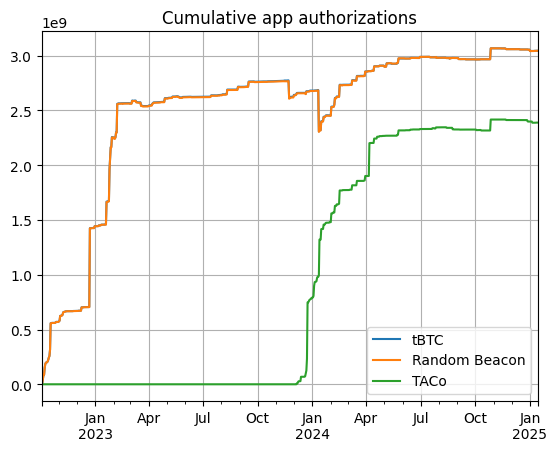

In [4]:
tbtc_auth_history = auth_history_daily.loc[:, (slice(
    None), 'tbtc')].map(lambda auth: int(auth/1e18))
rb_auth_history = auth_history_daily.loc[:, (slice(None), 'randombeacon')].map(
    lambda auth: int(auth/1e18))
taco_auth_history = auth_history_daily.loc[:, (slice(
    None), 'taco')].map(lambda auth: int(auth/1e18))

tbtc_auth_history.sum(axis=1).plot(
    title='Cumulative app authorizations', grid=True, legend=True, label='tBTC')
rb_auth_history.sum(axis=1).plot(title='Cumulative app authorizations',
                                 grid=True, legend=True, label='Random Beacon')
taco_auth_history.sum(axis=1).plot(
    title='Cumulative app authorizations', grid=True, legend=True, label='TACo')